<a href="https://colab.research.google.com/github/SpirinEgor/HSE.Deep_Unsupervised_Learning/blob/hw1/Homework/hw1/Homework1_MADE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! nvidia-smi

Tue Nov  9 21:16:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Homework 1

In [2]:
! if [ -d HSE.Deep_Unsupervised_Learning ]; then rm -Rf HSE.Deep_Unsupervised_Learning; fi
! git clone https://github.com/SpirinEgor/HSE.Deep_Unsupervised_Learning.git
%cd HSE.Deep_Unsupervised_Learning
! git checkout hw1

Cloning into 'HSE.Deep_Unsupervised_Learning'...
remote: Enumerating objects: 174, done.
remote: Counting objects: 100% (174/174), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 174 (delta 70), reused 151 (delta 54), pack-reused 0
Receiving objects: 100% (174/174), 26.20 MiB | 33.45 MiB/s, done.
Resolving deltas: 100% (70/70), done.
/content/HSE.Deep_Unsupervised_Learning
Branch 'hw1' set up to track remote branch 'hw1' from 'origin'.
Switched to a new branch 'hw1'


In [3]:
! pip install -r requirements.txt

In [4]:
! git pull

Already up to date.


In [5]:
! unzip -qq Homework/hw1/data/hw1_data.zip -d Homework/hw1/data/
! mv -v Homework/hw1/data/hw1_data/* Homework/hw1/data/
! rm -rf Homework/hw1/data/hw1_data/

renamed 'Homework/hw1/data/hw1_data/geoffrey-hinton.jpg' -> 'Homework/hw1/data/geoffrey-hinton.jpg'
renamed 'Homework/hw1/data/hw1_data/mnist_colored.pkl' -> 'Homework/hw1/data/mnist_colored.pkl'
renamed 'Homework/hw1/data/hw1_data/mnist.pkl' -> 'Homework/hw1/data/mnist.pkl'
renamed 'Homework/hw1/data/hw1_data/shapes_colored.pkl' -> 'Homework/hw1/data/shapes_colored.pkl'
renamed 'Homework/hw1/data/hw1_data/shapes.pkl' -> 'Homework/hw1/data/shapes.pkl'
renamed 'Homework/hw1/data/hw1_data/smiley.jpg' -> 'Homework/hw1/data/smiley.jpg'


In [6]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from made.trainer import ImageMADETrainer
from utils.hw1_utils import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [7]:
plt.rcParams["axes.labelsize"] = 25.0
plt.rcParams["xtick.labelsize"] = 20.0
plt.rcParams["ytick.labelsize"] = 20.0
plt.rcParams["legend.fontsize"] = 18.0

plt.rcParams["figure.figsize"] = [8.0, 6.0]

# MADE

In this question, you will implement [MADE](https://arxiv.org/abs/1502.03509). In the first part, you will use MADE to model a simple 2D joint distribution, and in the second half, you will train MADE on image datasets.

## Part (a) Fitting 2D Data

First, you will work with bivariate data of the form $x = (x_0,x_1)$, where $x_0, x_1 \in \{0, \dots, d\}$. We can easily visualize a 2D dataset by plotting a 2D histogram. Run the cell below to visualize our datasets.

Dataset 1


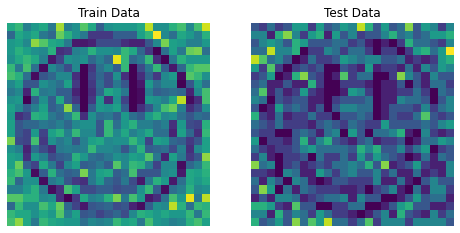

Dataset 2


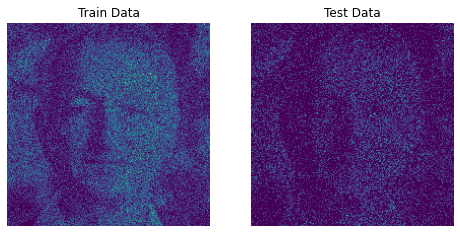

In [8]:
visualize_q1a_data(dataset_type=1)
visualize_q1a_data(dataset_type=2)
# you can access data with get_data_q1_a(dset_type=1)

Implement and train a MADE model through maximum likelihood to represent $p(x_0, x_1)$ on the given datasets, with any autoregressive ordering of your choosing. 

A few notes:
* You do not need to do training with multiple masks
* You made find it useful to one-hot encode your inputs. 

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. Visualize the learned 2D distribution by plotting a 2D heatmap


### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [9]:
def q1_a(train_data, test_data, d, dset_id):
    """
    train_data: An (n_train, 2) numpy array of integers in {0, ..., d-1}
    test_data: An (n_test, 2) numpy array of integers in {0, .., d-1}
    d: The number of possible discrete values for each random variable x1 and x2
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
            used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (d, d) of probabilities (the learned joint distribution)
    """
    config = {
        1: {
            "hidden_layers": [128, 128],
            "batch_size": 10,
            "test_batch_size": 20,
            "hyperparameters": {"lr": 2e-3, "n_epochs": 20, "weight_decay": 1e-4, "clip_norm": 10},
        },
        2: {
            "hidden_layers": [128, 128],
            "batch_size": 10,
            "test_batch_size": 20,
            "hyperparameters": {"lr": 2e-3, "n_epochs": 20, "weight_decay": 1e-4, "clip_norm": 10},
        },
    }

    made_trainer = ImageMADETrainer((2,), d, config[dset_id]["hidden_layers"], True)

    train_dataloader = DataLoader(train_data, batch_size=config[dset_id]["batch_size"], shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=config[dset_id]["test_batch_size"])

    train_losses, test_losses = made_trainer.train(
        train_dataloader, seed=7, test_dataloader=test_dataloader, **config[dset_id]["hyperparameters"]
    )

    return train_losses, test_losses, made_trainer.made.get_distribution()

### Results

Once you've implemented `q2_a`, execute the cells below to visualize and save your results



Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Train:   0%|          | 0/800 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch #0
	mean test loss: 3.2076896095275877


Train:   0%|          | 0/800 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch #1
	mean test loss: 3.2011629223823546


Train:   0%|          | 0/800 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch #2
	mean test loss: 3.1984449648857116


Train:   0%|          | 0/800 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch #3
	mean test loss: 3.19827175617218


Train:   0%|          | 0/800 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch #4
	mean test loss: 3.198336296081543


Train:   0%|          | 0/800 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch #5
	mean test loss: 3.1980140519142153


Train:   0%|          | 0/800 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch #6
	mean test loss: 3.198654503822327


Train:   0%|          | 0/800 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch #7
	mean test loss: 3.1985948419570924


Train:   0%|          | 0/800 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch #8
	mean test loss: 3.199112529754639


Train:   0%|          | 0/800 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch #9
	mean test loss: 3.1986178731918335


Train:   0%|          | 0/800 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch #10
	mean test loss: 3.198433287143707


Train:   0%|          | 0/800 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch #11
	mean test loss: 3.1990330457687377


Train:   0%|          | 0/800 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch #12
	mean test loss: 3.198674108982086


Train:   0%|          | 0/800 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch #13
	mean test loss: 3.199202220439911


Train:   0%|          | 0/800 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch #14
	mean test loss: 3.1993718719482422


Train:   0%|          | 0/800 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch #15
	mean test loss: 3.1991418981552124


Train:   0%|          | 0/800 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch #16
	mean test loss: 3.198487389087677


Train:   0%|          | 0/800 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch #17
	mean test loss: 3.1986812925338746


Train:   0%|          | 0/800 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch #18
	mean test loss: 3.1987389373779296


Train:   0%|          | 0/800 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch #19
	mean test loss: 3.1992647290229796
Final Test Loss: 3.1993


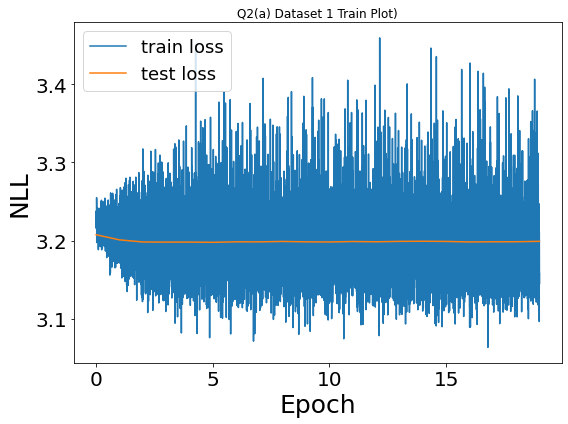

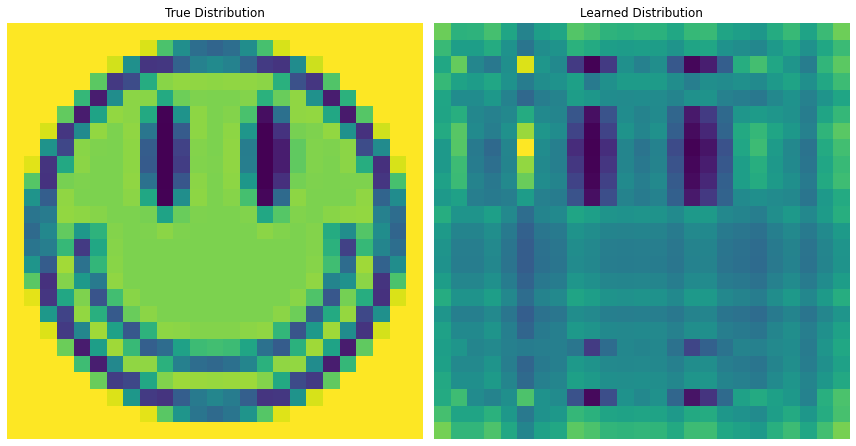

In [10]:
q1_save_results(1, "a", q1_a)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Train:   0%|          | 0/8000 [00:00<?, ?it/s]

Test:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch #0
	mean test loss: 5.275178364753723


Train:   0%|          | 0/8000 [00:00<?, ?it/s]

Test:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch #1
	mean test loss: 5.274955139636994


Train:   0%|          | 0/8000 [00:00<?, ?it/s]

Test:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch #2
	mean test loss: 5.275407952308655


Train:   0%|          | 0/8000 [00:00<?, ?it/s]

Test:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch #3
	mean test loss: 5.275613670825958


Train:   0%|          | 0/8000 [00:00<?, ?it/s]

Test:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch #4
	mean test loss: 5.275104450702667


Train:   0%|          | 0/8000 [00:00<?, ?it/s]

Test:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch #5
	mean test loss: 5.275563686847687


Train:   0%|          | 0/8000 [00:00<?, ?it/s]

Test:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch #6
	mean test loss: 5.274938439846038


Train:   0%|          | 0/8000 [00:00<?, ?it/s]

Test:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch #7
	mean test loss: 5.274754763126373


Train:   0%|          | 0/8000 [00:00<?, ?it/s]

Test:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch #8
	mean test loss: 5.274850060939789


Train:   0%|          | 0/8000 [00:00<?, ?it/s]

Test:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch #9
	mean test loss: 5.275281232833862


Train:   0%|          | 0/8000 [00:00<?, ?it/s]

Test:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch #10
	mean test loss: 5.274753673553467


Train:   0%|          | 0/8000 [00:00<?, ?it/s]

Test:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch #11
	mean test loss: 5.275238330364227


Train:   0%|          | 0/8000 [00:00<?, ?it/s]

Test:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch #12
	mean test loss: 5.275075542449951


Train:   0%|          | 0/8000 [00:00<?, ?it/s]

Test:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch #13
	mean test loss: 5.275173755645752


Train:   0%|          | 0/8000 [00:00<?, ?it/s]

Test:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch #14
	mean test loss: 5.2755753564834595


Train:   0%|          | 0/8000 [00:00<?, ?it/s]

Test:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch #15
	mean test loss: 5.275486617565155


Train:   0%|          | 0/8000 [00:00<?, ?it/s]

Test:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch #16
	mean test loss: 5.27507407617569


Train:   0%|          | 0/8000 [00:00<?, ?it/s]

Test:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch #17
	mean test loss: 5.275042555332184


Train:   0%|          | 0/8000 [00:00<?, ?it/s]

Test:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch #18
	mean test loss: 5.274923705101013


Train:   0%|          | 0/8000 [00:00<?, ?it/s]

Test:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch #19
	mean test loss: 5.275358990192413
Final Test Loss: 5.2754


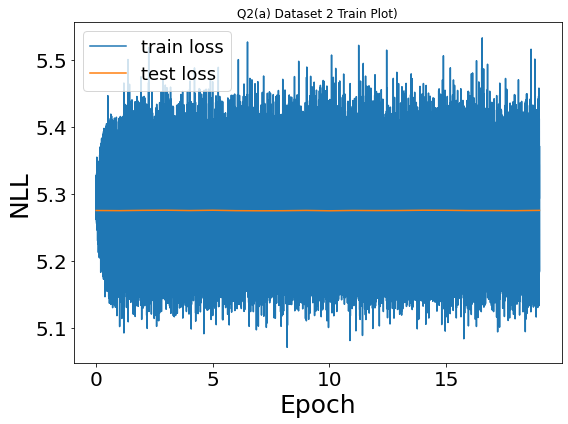

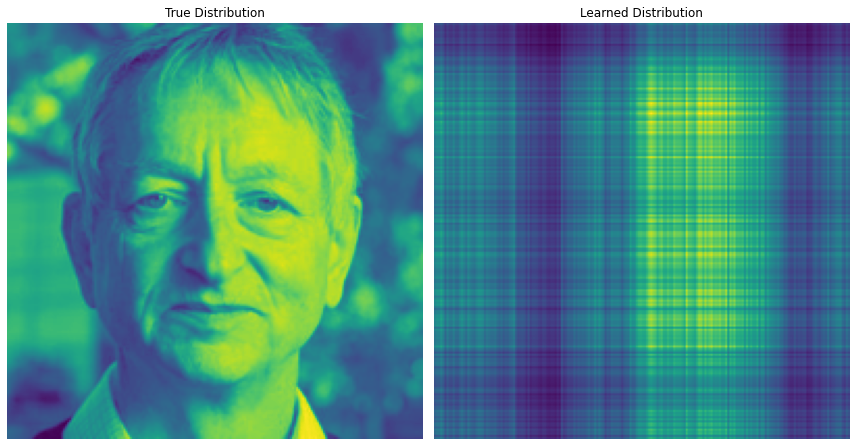

In [11]:
q1_save_results(2, "a", q1_a)

## Part (b) Shapes and MNIST
Now, we will work with a higher dimensional datasets, namely a shape dataset and MNIST. Run the cell below to visualize the two datasets

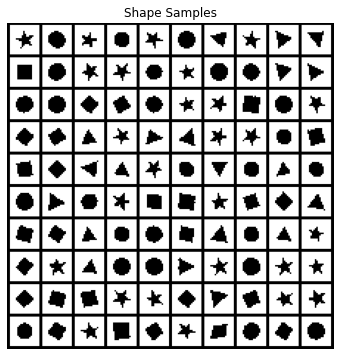

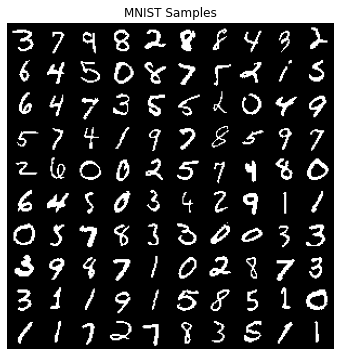

In [12]:
visualize_q1b_data(1)
visualize_q1b_data(2)
# you can access data with get_data_q1_b(dset_type=1)

Implement and train a MADE model on the given binary image datasets. Given some binary image of height $H$ and width $W$, we can represent image $x\in \{0, 1\}^{H\times W}$ as a flattened binary vector $x\in \{0, 1\}^{HW}$ to input into MADE to model $p_\theta(x) = \prod_{i=1}^{HW} p_\theta(x_i|x_{<i})$. Your model should output logits, after which you could apply a sigmoid over 1 logit, or a softmax over two logits (either is fine).

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [13]:
def q1_b(train_data, test_data, image_shape, dset_id, n_samples: int = 100):
    """
    train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    test_data: An (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    image_shape: (H, W), height and width of the image
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
            used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, W, 1) of samples with values in {0, 1}
    """
    config = {
        1: {
            "hidden_layers": [512, 512],
            "batch_size": 10,
            "test_batch_size": 20,
            "hyperparameters": {"lr": 1e-3, "n_epochs": 20, "weight_decay": 1e-4, "clip_norm": 10},
        },
        2: {
            "hidden_layers": [512, 512],
            "batch_size": 10,
            "test_batch_size": 20,
            "hyperparameters": {"lr": 1e-3, "n_epochs": 20, "weight_decay": 1e-4, "clip_norm": 10},
        },
    }

    train_data = np.transpose(train_data, (0, 3, 1, 2))
    test_data = np.transpose(test_data, (0, 3, 1, 2))
    H, W = image_shape

    made_trainer = ImageMADETrainer((1, H, W), 2, hidden_sizes=config[dset_id]["hidden_layers"])

    train_dataloader = DataLoader(train_data.astype(int), batch_size=config[dset_id]["batch_size"], shuffle=True)
    test_dataloader = DataLoader(test_data.astype(int), batch_size=config[dset_id]["test_batch_size"])

    train_losses, test_losses = made_trainer.train(
        train_dataloader, seed=7, test_dataloader=test_dataloader, **config[dset_id]["hyperparameters"]
    )

    samples = made_trainer.made.sample(n_samples, (1, H, W))
    samples = np.transpose(samples, (0, 2, 3, 1))

    return train_losses, test_losses, samples

### Results

Once you've implemented `q2_b`, execute the cells below to visualize and save your results



Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Train:   0%|          | 0/1048 [00:00<?, ?it/s]

Test:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch #0
	mean test loss: 0.08557055397166147


Train:   0%|          | 0/1048 [00:00<?, ?it/s]

Test:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch #1
	mean test loss: 0.06637889674968189


Train:   0%|          | 0/1048 [00:00<?, ?it/s]

Test:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch #2
	mean test loss: 0.06004742579327689


Train:   0%|          | 0/1048 [00:00<?, ?it/s]

Test:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch #3
	mean test loss: 0.056752189017004434


Train:   0%|          | 0/1048 [00:00<?, ?it/s]

Test:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch #4
	mean test loss: 0.05401914642916785


Train:   0%|          | 0/1048 [00:00<?, ?it/s]

Test:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch #5
	mean test loss: 0.0525411290427049


Train:   0%|          | 0/1048 [00:00<?, ?it/s]

Test:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch #6
	mean test loss: 0.05250451705522007


Train:   0%|          | 0/1048 [00:00<?, ?it/s]

Test:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch #7
	mean test loss: 0.05050719329052501


Train:   0%|          | 0/1048 [00:00<?, ?it/s]

Test:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch #8
	mean test loss: 0.0491521611975299


Train:   0%|          | 0/1048 [00:00<?, ?it/s]

Test:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch #9
	mean test loss: 0.04852962742249171


Train:   0%|          | 0/1048 [00:00<?, ?it/s]

Test:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch #10
	mean test loss: 0.048368609431717134


Train:   0%|          | 0/1048 [00:00<?, ?it/s]

Test:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch #11
	mean test loss: 0.04758776191208098


Train:   0%|          | 0/1048 [00:00<?, ?it/s]

Test:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch #12
	mean test loss: 0.04737936384148068


Train:   0%|          | 0/1048 [00:00<?, ?it/s]

Test:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch #13
	mean test loss: 0.047052095615201524


Train:   0%|          | 0/1048 [00:00<?, ?it/s]

Test:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch #14
	mean test loss: 0.04700768330030971


Train:   0%|          | 0/1048 [00:00<?, ?it/s]

Test:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch #15
	mean test loss: 0.046689532299836474


Train:   0%|          | 0/1048 [00:00<?, ?it/s]

Test:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch #16
	mean test loss: 0.045990149047639636


Train:   0%|          | 0/1048 [00:00<?, ?it/s]

Test:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch #17
	mean test loss: 0.04600083130929205


Train:   0%|          | 0/1048 [00:00<?, ?it/s]

Test:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch #18
	mean test loss: 0.046235675745540196


Train:   0%|          | 0/1048 [00:00<?, ?it/s]

Test:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch #19
	mean test loss: 0.045406252361006205
Final Test Loss: 0.0454


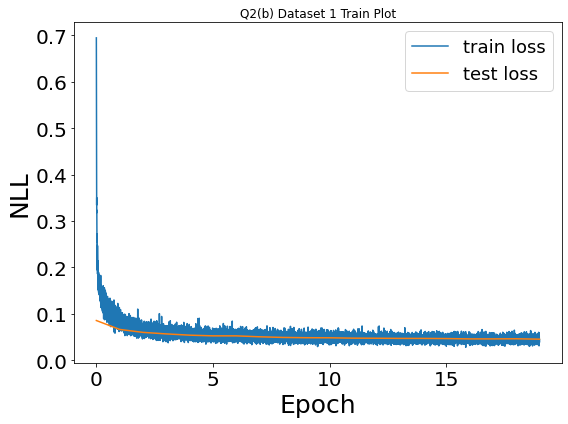

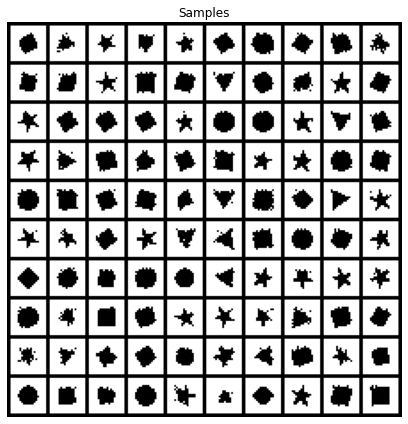

In [14]:
q1_save_results(1, "b", q1_b)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Train:   0%|          | 0/6000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch #0
	mean test loss: 0.13029111726582052


Train:   0%|          | 0/6000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch #1
	mean test loss: 0.12144296054542064


Train:   0%|          | 0/6000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch #2
	mean test loss: 0.11863147187232971


Train:   0%|          | 0/6000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch #3
	mean test loss: 0.11697576780617237


Train:   0%|          | 0/6000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch #4
	mean test loss: 0.11658157989382743


Train:   0%|          | 0/6000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch #5
	mean test loss: 0.1150279217660427


Train:   0%|          | 0/6000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch #6
	mean test loss: 0.11450545120239258


Train:   0%|          | 0/6000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch #7
	mean test loss: 0.11401877750456334


Train:   0%|          | 0/6000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch #8
	mean test loss: 0.11408069424331188


Train:   0%|          | 0/6000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch #9
	mean test loss: 0.11371094883978367


Train:   0%|          | 0/6000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch #10
	mean test loss: 0.11357713069021702


Train:   0%|          | 0/6000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch #11
	mean test loss: 0.1135776808410883


Train:   0%|          | 0/6000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch #12
	mean test loss: 0.11412491469085216


Train:   0%|          | 0/6000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch #13
	mean test loss: 0.11321168248355389


Train:   0%|          | 0/6000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch #14
	mean test loss: 0.11313852888345718


Train:   0%|          | 0/6000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch #15
	mean test loss: 0.11398007223010063


Train:   0%|          | 0/6000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch #16
	mean test loss: 0.11324288238584995


Train:   0%|          | 0/6000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch #17
	mean test loss: 0.11328688816726208


Train:   0%|          | 0/6000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch #18
	mean test loss: 0.11340278814733028


Train:   0%|          | 0/6000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch #19
	mean test loss: 0.11320090994238853
Final Test Loss: 0.1132


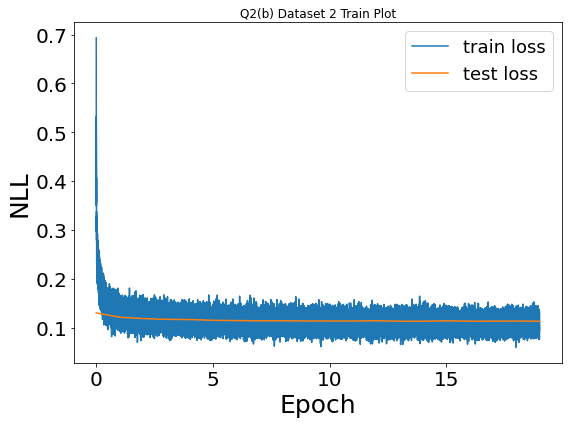

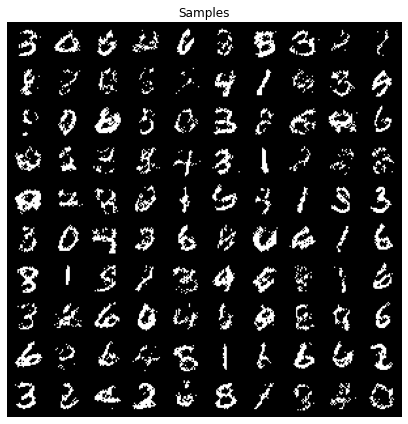

In [15]:
q1_save_results(2, "b", q1_b)